# Learn the basics pytorch

Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models. This tutorial introduces you to a complete ML workflow implemented in PyTorch, with links to learn more about each of these concepts.

We’ll use the FashionMNIST dataset to train a neural network that predicts if an input image belongs to one of the following classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, or Ankle boot.

In [1]:
# Importar pythorch

import torch

In [2]:
x = torch.rand(5, 3)
print(x)

tensor([[0.1083, 0.2834, 0.0833],
        [0.5806, 0.8470, 0.7531],
        [0.8291, 0.4197, 0.0991],
        [0.1334, 0.2367, 0.8419],
        [0.1295, 0.7557, 0.4398]])


In [3]:
## Verificar gpu disponibles
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
print(torch.cuda.memory_allocated())

1
NVIDIA GeForce RTX 3060 Ti
0


In [2]:
from torch import nn #importa modelo de redes neuronales
from torch.utils.data import DataLoader #libreria para importar por batches
from torchvision import datasets #Importar datos de ejemplor
from torchvision.transforms import ToTensor # Transformación de datos

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The torchvision.datasets module contains Dataset objects for many real-world vision data like CIFAR, COCO (full list here). In this tutorial, we use the FashionMNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [86]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


We can index Datasets manually like a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

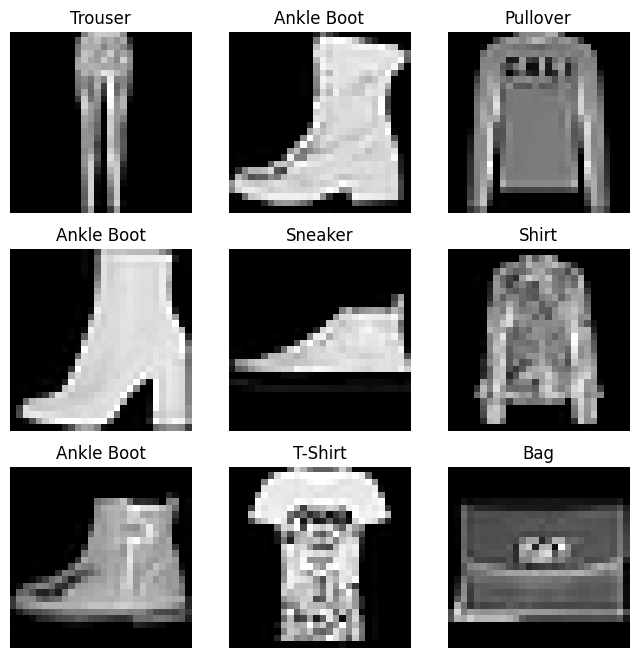

In [80]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [81]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [82]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [87]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [88]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [89]:
import time

start = time.time()



epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
end = time.time()
print("DONE. Time required: ", end - start)


Epoch 1
-------------------------------
loss: 2.258406  [   64/60000]
loss: 2.254904  [ 6464/60000]
loss: 2.225692  [12864/60000]
loss: 2.227431  [19264/60000]
loss: 2.190939  [25664/60000]
loss: 2.164209  [32064/60000]
loss: 2.181340  [38464/60000]
loss: 2.139028  [44864/60000]
loss: 2.126287  [51264/60000]
loss: 2.094447  [57664/60000]
Test Error: 
 Accuracy: 54.6%, Avg loss: 2.083115 

Epoch 2
-------------------------------
loss: 2.089345  [   64/60000]
loss: 2.086081  [ 6464/60000]
loss: 2.006082  [12864/60000]
loss: 2.030274  [19264/60000]
loss: 1.953368  [25664/60000]
loss: 1.903603  [32064/60000]
loss: 1.925132  [38464/60000]
loss: 1.839702  [44864/60000]
loss: 1.831119  [51264/60000]
loss: 1.757196  [57664/60000]
Test Error: 
 Accuracy: 61.8%, Avg loss: 1.753887 

Epoch 3
-------------------------------
loss: 1.789156  [   64/60000]
loss: 1.768602  [ 6464/60000]
loss: 1.627970  [12864/60000]
loss: 1.676399  [19264/60000]
loss: 1.560155  [25664/60000]
loss: 1.536844  [32064/600

In [99]:
torch.rand(2, 2, 2, device=device)

tensor([[[0.5026, 0.4023],
         [0.0940, 0.6767]],

        [[0.7151, 0.7846],
         [0.0390, 0.8278]]], device='cuda:0')